In [1]:
import sys
import os

# Add the src directory to sys.path
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
import pymc as pm
import arviz as az 

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [7]:
import pandas as pd

# Load processed data
df = pd.read_csv('../data/processed/brent_clean.csv', parse_dates=['Date'], index_col='Date')



In [8]:
print(df.columns)

Index(['Price', 'daily_return', 'volatility'], dtype='object')


In [11]:
import pymc as pm
import pytensor.tensor as pt # <-- Corrected import
import numpy as np

data = np.random.randn(100)
n = len(data)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    
    # Use `pt` instead of `at`
    mu = pm.math.switch(tau >= pt.arange(n), mu1, mu2) 
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=data)

    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.98,
        return_inferencedata=True
    )

    pm.summary(trace)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 186 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [12]:
import arviz as az
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,43.212,34.462,0.000,98.000,2.192,0.544,269.0,626.0,1.01
mu1,-0.115,0.329,-0.882,0.383,0.014,0.014,648.0,1031.0,1.01
mu2,0.031,0.311,-0.639,0.564,0.008,0.024,1906.0,987.0,1.00


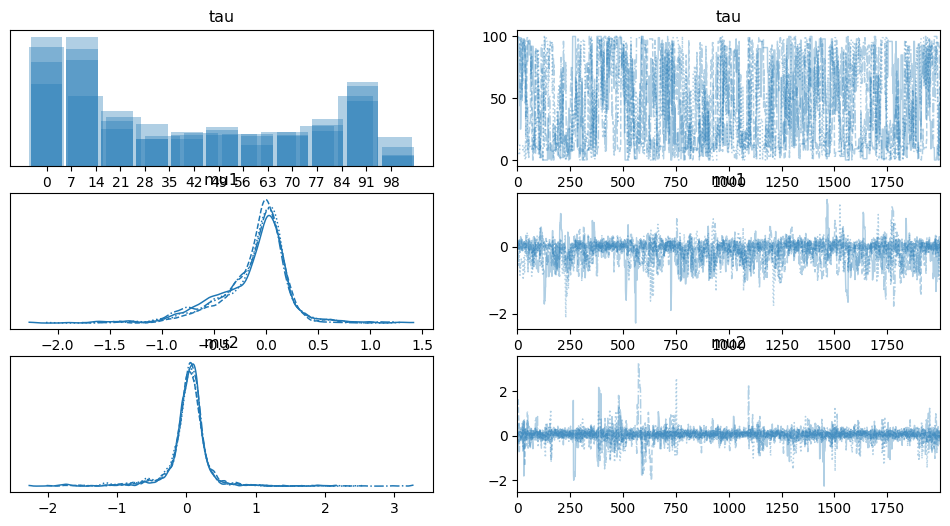

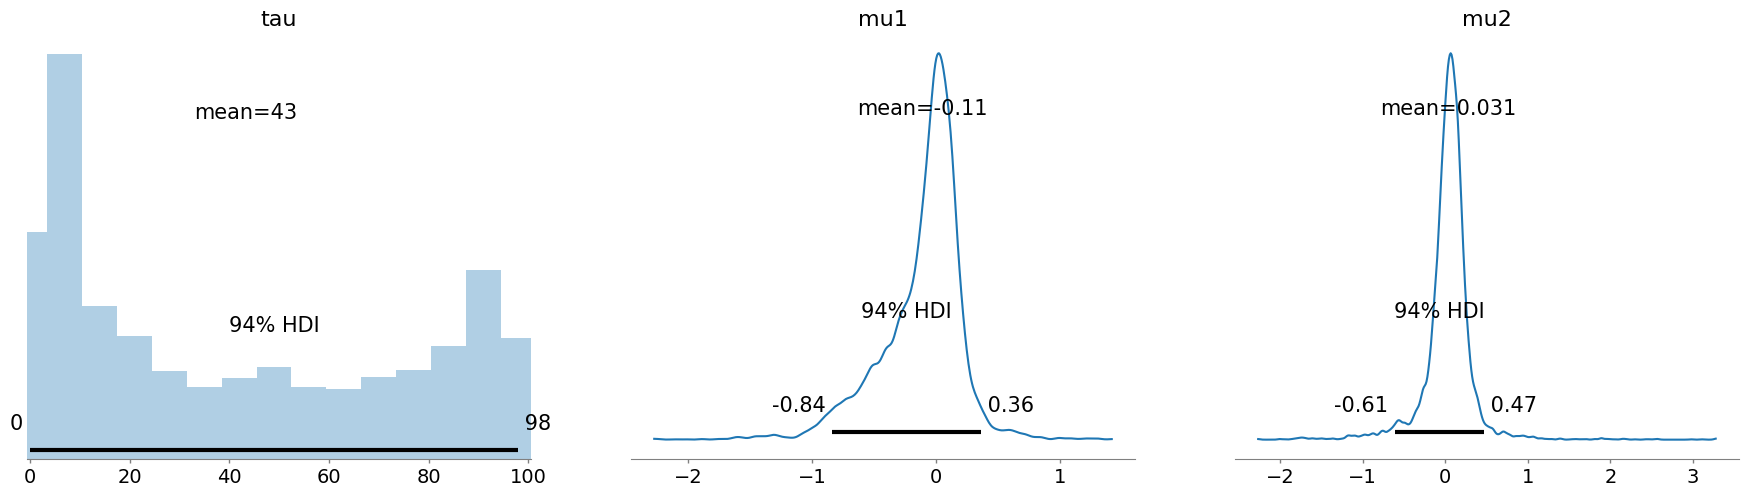

In [13]:
az.plot_trace(trace)
plt.show()

az.plot_posterior(trace)
plt.show()

In [14]:
tau_samples = trace.posterior['tau'].values.flatten()
estimated_tau = int(np.mean(tau_samples))
print("Estimated change point (index):", estimated_tau)


Estimated change point (index): 43


In [15]:
path = "../data/processed/brent_clean.csv"

try:
    data = pd.read_csv(path)

    # Use format='mixed' to infer the format for each date string
    data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=False)
    data = data.sort_values(by='Date')
    data = data.set_index('Date')

    # Handle missing values by interpolation, as suggested for robust analysis
    # This is crucial for time series data to maintain continuity
    data['Price'] = data['Price'].interpolate(method='time')

    # Drop any rows where 'Price' might still be NaN after interpolation (e.g., at the very beginning/end if no surrounding data)
    data = data.dropna(subset=['Price'])

    # For Bayesian analysis of volatility, it's often better to work with log returns
    # Log returns help in achieving stationarity and are directly related to volatility.
    # We use.diff() and.dropna() to handle the first NaN value from the difference calculation.
    data['Log_Return'] = np.log(data['Price']).diff().dropna()

    # The time series for analysis will be the 'Price' for ruptures and 'Log_Return' for PyMC
    time_series_price = data['Price']
    time_series_log_return = data['Log_Return'].dropna() # Ensure log returns are also dropped if NaN

    print("Brent Oil Prices Time Series Head:")
    display(time_series_price.head())
    print("\nBrent Oil Prices Time Series Tail:")
    display(time_series_price.tail())
    print("\nBrent Oil Log Returns Time Series Head:")
    display(time_series_log_return.head())
    print("\nBrent Oil Log Returns Time Series Tail:")
    display(time_series_log_return.tail())

except FileNotFoundError:
    print(f"Error: The file '{path}' was not found. Please update the 'path' variable with the correct file location.")

except Exception as e:
    print(f"An error occurred during data loading or preprocessing: {e}")


Brent Oil Prices Time Series Head:


Date
1987-05-20    18.63
1987-05-21    18.45
1987-05-22    18.55
1987-05-25    18.60
1987-05-26    18.63
Name: Price, dtype: float64


Brent Oil Prices Time Series Tail:


Date
2020-04-15    19.80
2020-04-16    18.69
2020-04-17    19.75
2020-04-20    17.36
2020-04-21     9.12
Name: Price, dtype: float64


Brent Oil Log Returns Time Series Head:


Date
1987-05-21   -0.009709
1987-05-22    0.005405
1987-05-25    0.002692
1987-05-26    0.001612
1987-05-27   -0.001612
Name: Log_Return, dtype: float64


Brent Oil Log Returns Time Series Tail:


Date
2020-04-15   -0.093472
2020-04-16   -0.057693
2020-04-17    0.055165
2020-04-20   -0.128985
2020-04-21   -0.643699
Name: Log_Return, dtype: float64

In [16]:
print(type(data))


<class 'pandas.core.frame.DataFrame'>


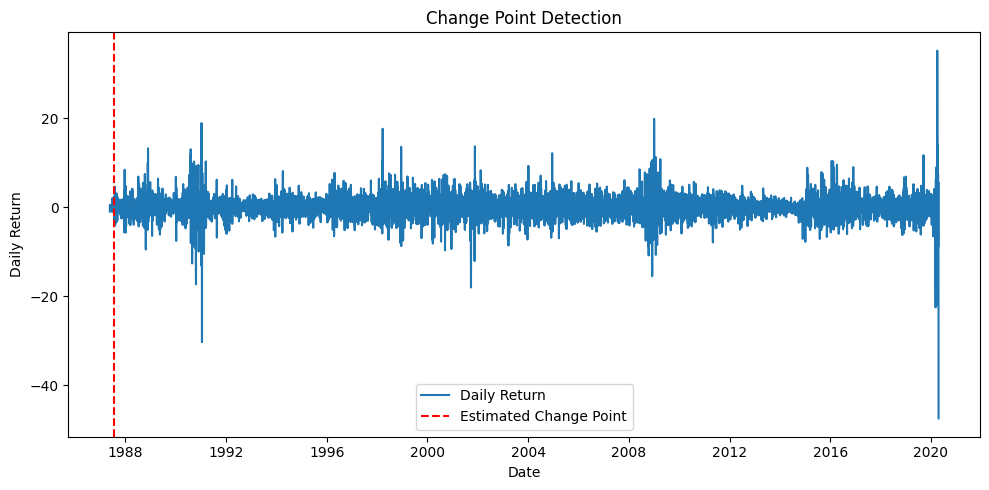

In [20]:
# Assuming df is already loaded with 'Date' as the index
# This will create a new DataFrame with 'Date' as a regular column
df_plot = df.reset_index()

# Now, use df_plot for your plotting
plt.figure(figsize=(10, 5))
plt.plot(df_plot['Date'], df_plot['daily_return'], label='Daily Return')
plt.axvline(x=df_plot['Date'].iloc[estimated_tau], color='red', linestyle='--', label='Estimated Change Point')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Change Point Detection')
plt.legend()
plt.tight_layout()

import os
os.makedirs('reports/figures', exist_ok=True)
plt.savefig('reports/figures/change_point_plot.png')
plt.show()

In [21]:
print(data.shape)

(8360, 4)



Detected Change Point Indices (ruptures on Price): [65, 145, 190, 225, 270, 330, 390, 415, 465, 510, 605, 660, 705, 735, 805, 820, 840, 850, 855, 870, 875, 880, 890, 905, 925, 935, 955, 1060, 1115, 1155, 1265, 1395, 1550, 1665, 1760, 1805, 1845, 2000, 2060, 2175, 2250, 2270, 2350, 2370, 2475, 2505, 2630, 2675, 2695, 2725, 2805, 2875, 2895, 2920, 3000, 3020, 3075, 3120, 3165, 3210, 3240, 3255, 3285, 3290, 3335, 3355, 3365, 3385, 3420, 3435, 3445, 3460, 3475, 3485, 3535, 3580, 3620, 3640, 3670, 3750, 3765, 3810, 3830, 3870, 3915, 3955, 3990, 4015, 4020, 4030, 4060, 4115, 4140, 4160, 4210, 4260, 4310, 4335, 4355, 4370, 4410, 4420, 4440, 4445, 4465, 4470, 4485, 4520, 4525, 4550, 4575, 4590, 4600, 4630, 4640, 4660, 4680, 4705, 4725, 4740, 4750, 4765, 4790, 4800, 4810, 4815, 4825, 4835, 4865, 4885, 4900, 4910, 4915, 4925, 4975, 4995, 5000, 5010, 5030, 5055, 5080, 5090, 5120, 5145, 5165, 5190, 5200, 5205, 5225, 5240, 5255, 5275, 5285, 5290, 5300, 5310, 5315, 5320, 5330, 5335, 5345, 5355, 537

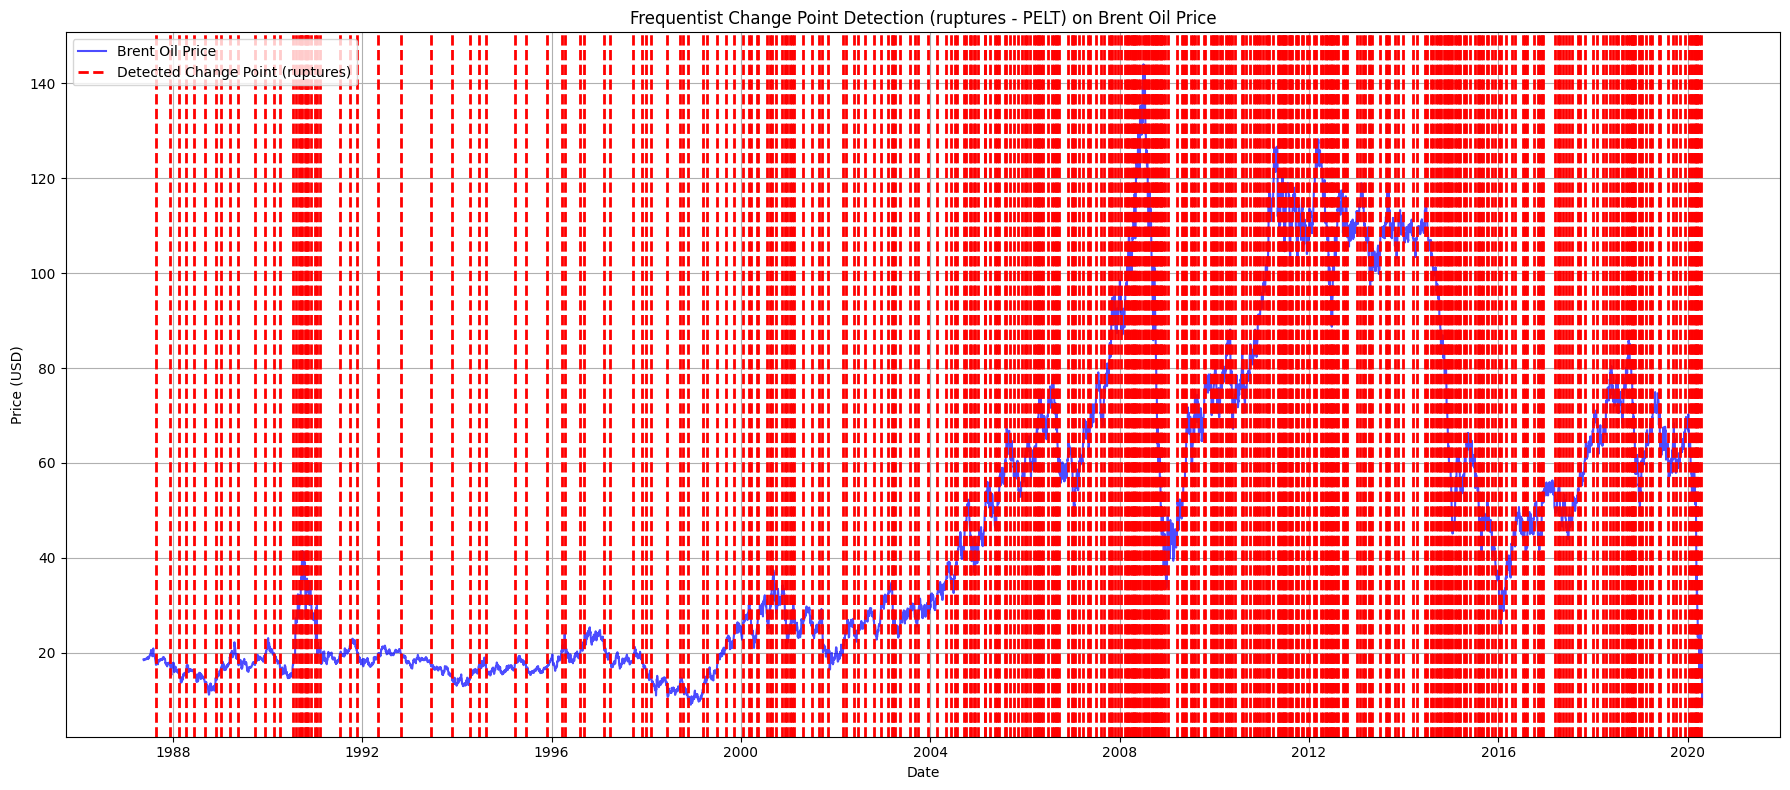

In [23]:
# Convert time series to a numpy array for the ruptures library
# We use the raw price data here to detect shifts in the mean price level.
if 'time_series_price' in locals() and not time_series_price.empty: # Check if time_series_price was successfully created and is not empty
    signal_array_ruptures = time_series_price.values.reshape(-1, 1) # Reshape for ruptures

    # Define the model and algorithm
    # 'l2' (L2 norm) cost function is good for detecting changes in mean.
    model_ruptures = "l2"
    algo_ruptures = rpt.Pelt(model=model_ruptures).fit(signal_array_ruptures)

    # Predict change points
    # The 'pen' (penalty) parameter controls the number of detected change points.
    # A higher penalty results in fewer change points.
    # You might need to tune this penalty for your specific dataset.
    # A common heuristic is 3 * log(n_samples) or 4 * log(n_samples).

    penalty_value_ruptures = 3 * np.log(len(time_series_price))
    change_points_ruptures = algo_ruptures.predict(pen=penalty_value_ruptures)

    # The 'ruptures' library returns the index of the last point of each segment.
    # We usually exclude the last point if it's just the end of the series.
    if change_points_ruptures and change_points_ruptures[-1] == len(time_series_price):
        detected_change_point_indices_ruptures = change_points_ruptures[:-1]
    else:
        detected_change_point_indices_ruptures = change_points_ruptures

    print(f"\nDetected Change Point Indices (ruptures on Price): {detected_change_point_indices_ruptures}")

    # Convert indices to dates for plotting
    detected_change_point_dates_ruptures = time_series_price.index[detected_change_point_indices_ruptures]
    print(f"Detected Change Point Dates (ruptures on Price): {detected_change_point_dates_ruptures.tolist()}")

    # Visualization for ruptures
    plt.figure(figsize=(18, 8))
    plt.plot(time_series_price.index, time_series_price.values, label='Brent Oil Price', color='blue', alpha=0.7)
    # Plot change points with labels, ensuring only one label is created for the legend
    for i, cp_date in enumerate(detected_change_point_dates_ruptures):
        plt.axvline(x=cp_date, color='red', linestyle='--', linewidth=2, label='Detected Change Point (ruptures)' if i == 0 else "")
    plt.title('Frequentist Change Point Detection (ruptures - PELT) on Brent Oil Price')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Frequentist Change Point Detection as price time series data is not available or empty.")